In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

# Loading Data

In [17]:
data = pd.read_csv('./data_processed/data_stats.csv', index_col=0)

data['los_'] = (data.los <= 4).astype(int)

data

,subject_id,intime,los,gender,age,heart_rate,respiratory_rate,hematocrit,rdw,platelet,...,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED,insurance_Medicare,insurance_Other,race,language,marital_status,insurance,los_
0,10024331,2141-03-18 19:36:08,4.105710,1,0.622768,-0.922776,-0.562083,-0.203896,-1.315486,-0.620134,...,1,0,0,1,0,WHITE,ENGLISH,MARRIED,Medicare,0
1,10025647,2176-09-22 17:57:15,1.968100,1,1.364195,-0.922776,-0.043414,0.163687,-0.324740,-0.356911,...,1,0,0,1,0,WHITE,ENGLISH,MARRIED,Medicare,1
2,10037975,2185-01-17 19:12:12,4.878240,1,-0.225030,0.088031,3.068597,1.371460,0.309338,-1.486846,...,1,0,0,1,0,OTHER,ENGLISH,MARRIED,Medicare,0
3,10056223,2122-09-23 15:08:45,5.041060,1,-0.824804,0.037490,0.129475,-0.729015,-0.285110,-1.095220,...,0,1,0,0,0,HISPANIC/LATINO,?,SINGLE,Medicaid,0
4,10063856,2174-03-08 01:04:16,1.374750,0,-0.473584,-2.287366,-0.389193,-0.116376,-1.355116,0.169536,...,1,0,0,0,1,WHITE,ENGLISH,MARRIED,Other,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4076,19890872,2190-07-30 12:49:21,2.009390,0,0.903956,-1.124938,0.302365,-0.431448,-0.919187,-0.151468,...,1,0,0,0,1,WHITE,ENGLISH,MARRIED,Other,1
4077,19898425,2154-08-13 22:29:01,0.757627,0,-1.154151,0.593434,-0.562083,-1.201622,1.260454,0.766604,...,1,0,0,0,0,HISPANIC/LATINO,ENGLISH,MARRIED,Medicaid,1
4078,19923690,2142-07-20 22:02:00,1.825230,0,2.190119,0.189112,-0.389193,2.614242,-0.483259,-0.048747,...,0,0,1,1,0,WHITE,ENGLISH,WIDOWED,Medicare,1
4079,19940147,2127-11-11 12:29:24,14.175100,0,-0.301237,0.088031,0.302365,-1.166614,-0.483259,-1.165841,...,1,0,0,1,0,WHITE,ENGLISH,MARRIED,Medicare,0


# Statistcal Test

In [18]:
data.columns

Index(['subject_id', 'intime', 'los', 'gender', 'age', 'heart_rate',
       'respiratory_rate', 'hematocrit', 'rdw', 'platelet', 'mcv', 'mch',
       'hemoglobin', 'die_in_icu', 'uc_only', 'cd_only', 'language_ENGLISH',
       'race_BLACK', 'race_HISPANIC/LATINO', 'race_OTHER', 'race_WHITE',
       'marital_status_MARRIED', 'marital_status_SINGLE',
       'marital_status_WIDOWED', 'insurance_Medicare', 'insurance_Other',
       'race', 'language', 'marital_status', 'insurance', 'los_'],
      dtype='object')

## Lab

对比 LOS 两组之间是否有明显差异

In [19]:
for col in ['age', 'heart_rate', 'respiratory_rate', 'hematocrit', 'rdw', 'platelet','mcv', 'mch', 'hemoglobin']:
    x1 = data.loc[data.los_ == 0, col]
    x2 = data.loc[data.los_ == 1, col]
    
    x1 = np.array(x1)
    x2 = np.array(x2)
    
    # U-statistics
    u_statistic, u_p_value = stats.mannwhitneyu(x1, x2, alternative='two-sided')
    
    # t-statistics
    t_statistic, t_p_value = stats.ttest_ind(x1, x2, equal_var=False)
    
    print(f'{col}\n  los=0: ({x1.mean():.2f}, {x1.std():.2f}) los=1: ({x2.mean():.2f}, {x2.std():.2f})')
    print(f'    u-statistic: {u_statistic:.4f} p: {u_p_value:.4f} significant: {u_p_value < 0.05}')
    print(f'    t-statistic: {t_statistic:.4f} p: {t_p_value:.4f} significant: {t_p_value < 0.05}')
    print()

age
  los=0: (-0.04, 0.98) los=1: (-0.07, 1.09)
    u-statistic: 36357.0000 p: 0.8672 significant: False
    t-statistic: 0.3468 p: 0.7291 significant: False

heart_rate
  los=0: (0.18, 0.96) los=1: (-0.02, 1.00)
    u-statistic: 40708.0000 p: 0.0180 significant: True
    t-statistic: 2.1576 p: 0.0320 significant: True

respiratory_rate
  los=0: (0.31, 1.01) los=1: (-0.06, 1.01)
    u-statistic: 44489.0000 p: 0.0000 significant: True
    t-statistic: 3.8556 p: 0.0002 significant: True

hematocrit
  los=0: (-0.01, 0.97) los=1: (0.13, 1.05)
    u-statistic: 33573.5000 p: 0.2157 significant: False
    t-statistic: -1.4972 p: 0.1357 significant: False

rdw
  los=0: (-0.06, 1.03) los=1: (-0.25, 0.94)
    u-statistic: 39356.0000 p: 0.0926 significant: False
    t-statistic: 2.0127 p: 0.0454 significant: True

platelet
  los=0: (-0.04, 1.00) los=1: (nan, nan)
    u-statistic: nan p: nan significant: False
    t-statistic: nan p: nan significant: False

mcv
  los=0: (0.06, 0.95) los=1: (-0.06,

## 'race', 'language', 'marital_status', 'insurance'

In [20]:
data['type'] = data.loc[:, ['uc_only', 'cd_only']].apply(lambda x: x.iloc[0] + 2*x.iloc[1], axis=1)

In [21]:
columns = ['type']

for index in ['race', 'language', 'marital_status', 'insurance']:
    res = pd.pivot_table(
        data=data,
        values='los',
        index=index,
        columns=columns,
        aggfunc=['mean', 'std', 'count']
    )

    print(res)

                     mean                           std                      \
type                    0         1         2         0         1         2   
race                                                                          
ASIAN            1.108660  5.652757  3.074340       NaN  3.581111       NaN   
BLACK            1.508489  3.768722  2.086715  1.192283  6.088566  1.666521   
HISPANIC/LATINO  1.191420  2.556713  3.907187       NaN  1.642190  4.159725   
OTHER            2.508280  2.959220  4.168294  1.178761  2.972864  4.351154   
WHITE            3.298588  3.319089  3.240548  3.168231  5.068688  3.803972   

                count            
type                0    1    2  
race                             
ASIAN               1    3    1  
BLACK               2   27   16  
HISPANIC/LATINO     1    6    8  
OTHER               2   26   25  
WHITE              28  254  252  
              mean                           std                     count  \
type             

### Race

In [22]:
# Race
mean_los = (
    data.groupby(['race', 'type'])
    .agg({'los': 'mean'})
    .reset_index()
)

mean_los

,race,type,los
0,ASIAN,0,1.108660
1,ASIAN,1,5.652757
2,ASIAN,2,3.074340
3,BLACK,0,1.508489
4,BLACK,1,3.768722
5,BLACK,2,2.086715
6,HISPANIC/LATINO,0,1.191420
7,HISPANIC/LATINO,1,2.556713
8,HISPANIC/LATINO,2,3.907187
9,OTHER,0,2.508280


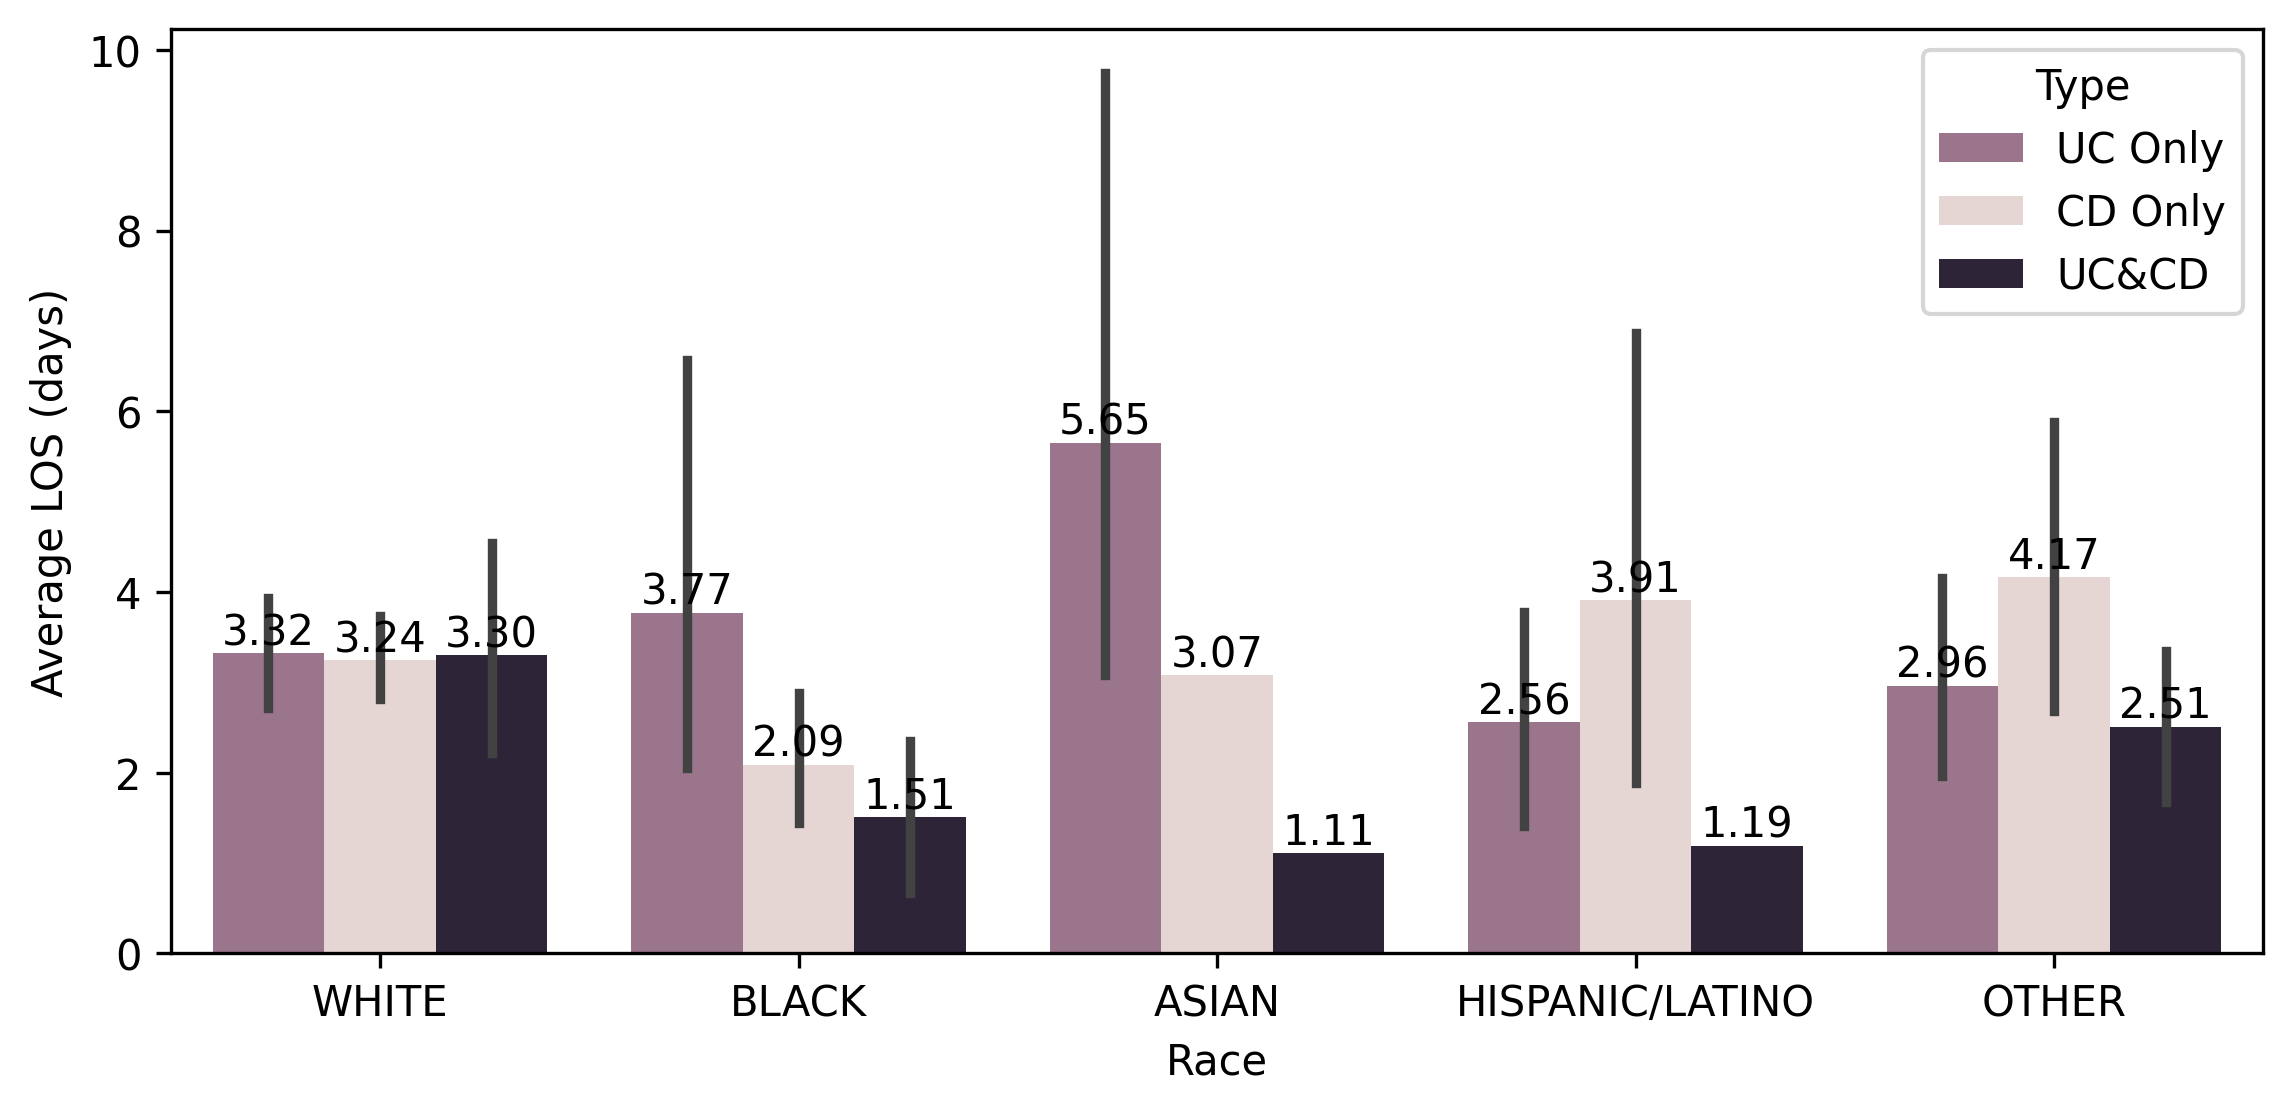

In [23]:
plt.figure(figsize=(9, 4), dpi=300)

race_order = ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC/LATINO','OTHER']

data['race'] = pd.Categorical(data['race'], 
                              categories=race_order,
                              ordered=True)

data['hue'] = data.type.apply(lambda x: {0: 'UC&CD', 1: 'UC Only', 2: 'CD Only'}[x])

color_mapping = {
    'UC&CD': (0.17638493922735704, 0.13387019035781797, 0.2266899340897154, 1),
    'UC Only': (0.6301710208255752, 0.4352806634991918, 0.5531285070707633, 1),
    'CD Only': (0.9145040817242649, 0.8311962996810209, 0.8139132380746315, 1),
}

ax = sns.barplot(data=data, 
                 x='race',
                 y='los', 
                 hue='hue', 
                 palette=color_mapping,
                 legend=True)

# 在每个条上显示值
for p in ax.patches:
    if p.get_height() > 0:
        ax.text(p.get_x() + p.get_width() / 2.,  # x位置
                p.get_height(),  # y位置
                '{:1.2f}'.format(p.get_height()),  # 文本
                ha='center',  # 水平居中
                va='bottom')  # 垂直底部


# 设置图表的其他属性
plt.xlabel('Race')
plt.ylabel('Average LOS (days)')
plt.legend(title='Type')
plt.show()